# 🛠 | Install Libraries

# Reference
https://www.kaggle.com/code/awsaf49/detect-fake-text-kerasnlp-tf-torch-jax-train#%E2%98%8E%EF%B8%8F-%7C-Callbacks

In [1]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install --upgrade -q wandb git+https://github.com/soumik12345/wandb-addons

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.


# 📚 | Import Libraries 

In [2]:
import keras_nlp
import keras_core as keras
import keras_core.backend as K


import torch
# import jax
import tensorflow as tf
# from tensorflow import keras
# import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


/tmp/ipykernel_104/2472500706.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


## Library Version

In [3]:
print("TensorFlow:", tf.__version__)
# print("JAX:", jax.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.13.0
Keras: 0.1.7
KerasNLP: 0.6.3


# ⚙️ | Configuration

In [4]:
class CFG:
    verbose = 0  # Verbosity
    
    wandb = True  # Weights & Biases logging
    competition = 'llm-detect-ai-generated-text'  # Competition name
    _wandb_kernel = 'awsaf49'  # WandB kernel
    comment = 'DebertaV3-MaxSeq_200-ext_s-torch'  # Comment description
    
    preset = "deberta_v3_base_en"  # Name of pretrained models
    sequence_length = 200  # Input sequence length
    
    device = 'TPU'  # Device
    
    seed = 42  # Random seed
    
    num_folds = 5  # Total folds
    selected_folds = [0, 1, 2]  # Folds to train on
    
    epochs = 3 # Training epochs
    batch_size = 3  # Batch size
    drop_remainder = True  # Drop incomplete batches
    cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM
    
    scheduler = 'cosine'  # Learning rate scheduler
    
    class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

# ♻️ | Reproducibility
 
Sets value for random seed to produce similar result in each run.


In [5]:
keras.utils.set_random_seed(CFG.seed)

# 💾 | Hardware
Following codes automatically detects hardware (TPU or GPU).


In [6]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # Connect to TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
        # Set TPU strategy
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [7]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on GPU | Num of GPUs:  2


# 📁 | Dataset Path

In [8]:
# Data path
BASE_PATH = '/kaggle/input/llm-detect-ai-generated-text'

## 📖 | Meta Data

1. {test|train}_essays.csv
     *         id - A unique identifier for each essay.
     *         prompt_id - Identifies the prompt the essay was written in response to.
     *         text - The essay text itself.
     *         generated - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the 
2. target and is not present in test_essays.csv.
    sample_submission.csv - is the valid sample submission.



## Train Data

# Train Data: 1,378
# Sample:


,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real


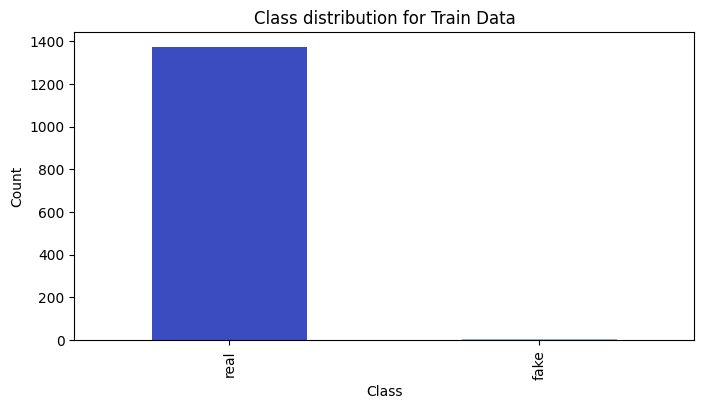

In [9]:
df = pd.read_csv(f'{BASE_PATH}/train_essays.csv')  # Read CSV file into a DataFrame
df['label'] = df.generated.copy()
df['name'] = df.generated.map(CFG.label2name)  # Map answer labels using name-to-label mapping

# Display information about the train data
print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()


## External Datasets

We'll be utilizing the following external datasets:

* [Proper Train Dataset](https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/) @thedrcat
* [ArguGPT](https://www.kaggle.com/datasets/alejopaullier/argugpt) @alejopaullier


# External Data: 28,210
# Sample:


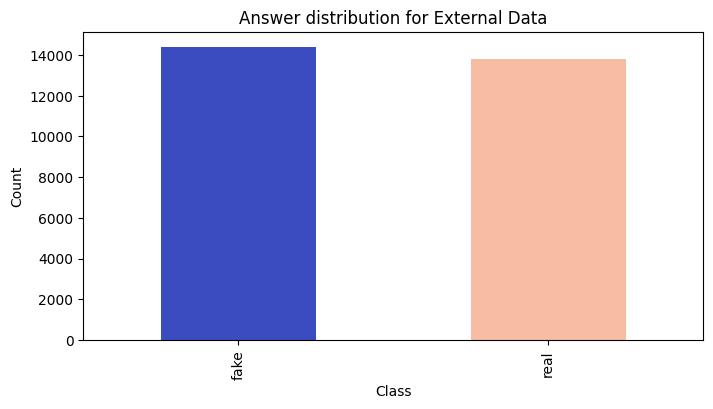

In [10]:
# Load external data
ext_df1 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')
ext_df2 = pd.read_csv('/kaggle/input/argugpt/argugpt.csv')[['id','text','model']]

ext_df2.rename(columns={'model':'source'}, inplace=True)
ext_df2['label'] = 1

ext_df = pd.concat([
    ext_df1[ext_df1.source=='persuade_corpus'].sample(10000),
    ext_df1[ext_df1.source!='persuade_corpus'],
#     ext_df2,
])

ext_df['name'] = ext_df.label.map(CFG.label2name)

# Display information about the external data
print("# External Data: {:,}".format(len(ext_df)))
print("# Sample:")
ext_df.head(2)

# Show distribution of answers using a bar plot
plt.figure(figsize=(8, 4))
ext_df.name.value_counts().plot.bar(color=[cmap(0.0), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()

## Combine External and Train Data

In [11]:
df = ext_df.copy().reset_index(drop=True) # pd.concat([ext_df, df], axis=0)
df.head()

,essay_id,text,label,source,prompt,fold,name
0,83BB96F966DB,Students would benefit from being able to atte...,0,persuade_corpus,NaN,2,real
1,80D6E256AA49,Landform or alien? The face on Mars looks pret...,0,persuade_corpus,NaN,2,real
2,4A028F63CFCA,The human body is a complex network of muscles...,0,persuade_corpus,NaN,7,real
3,5782F64504B9,Summer projects are a means by which schools a...,0,persuade_corpus,NaN,9,real
4,97DD2D770B03,"Dear Mr. Senator,\n\nI have decided to express...",0,persuade_corpus,NaN,6,real


# 🔪 | Data Split

In the code snippet provided below, we will divide the existing train data into folds using a stratification of label column.

In [12]:
from sklearn.model_selection import StratifiedKFold  # Import package

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)  # Initialize K-Fold

df = df.reset_index(drop=True)  # Reset dataframe index

df['stratify'] = df.label.astype(str)+df.source.astype(str)

df["fold"] = -1  # New 'fold' column

# Assign folds using StratifiedKFold
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'])):
    df.loc[val_idx, 'fold'] = fold

# Display label distribution for each fold
df.groupby(["fold", "name", "source"]).size()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


fold  name  source           
0     fake  chat_gpt_moth         484
            darragh_claude_v6     200
            darragh_claude_v7     200
            falcon_180b_v1        211
            llama2_chat           484
                                 ... 
4     fake  radek_500             100
            train_essays            1
      real  original_moth         484
            persuade_corpus      2000
            train_essays          275
Length: 63, dtype: int64

# 🍽️ | Preprocessing
**What it does**: The preprocessor takes input strings and transforms them into a dictionary (token_ids, padding_mask) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important**: Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming "The quick brown fox" into ["the", "qu", "##ick", "br", "##own", "fox"], we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

In [13]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

2464616/2464616 [==============================] - 0s 0us/step


Examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as (num_choices,sequence_length).

In [14]:
inp = preprocessor(df.text.iloc[0])  # Process text for the first row

# Display the shape of each processed output
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : (200,)
padding_mask : (200,)


The preprocessing_fn function is to transform each text option using the dataset.map(preprocessing_fn) method.

In [15]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using tf.data.Dataset for data processing. Notable aspects of tf.data include its ability to simplify pipeline construction and represent components in sequences.

In [16]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)  # Create slices
    ds = tf.data.Dataset.from_tensor_slices(slices)  # Create dataset from slices
    ds = ds.cache() if cache else ds  # Cache dataset if enabled
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)  # Map preprocessing function
    ds = ds.repeat() if repeat else ds  # Repeat dataset if enabled
    opt = tf.data.Options()  # Create dataset options
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Shuffle dataset if enabled
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)  # Set dataset options
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)  # Batch dataset
    ds = ds.prefetch(AUTO)  # Prefetch next batch
    return ds  # Return the built dataset

## Fetch Train/Valid Dataset

The function below generates the training and validation datasets for a given fold.

In [17]:
def get_datasets(fold):
    train_df = df[df.fold!=fold].sample(frac=1)  # Get training fold data
        
    train_texts = train_df.text.tolist()  # Extract training texts
    train_labels = train_df.label.tolist()  # Extract training labels
    
    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,
                             shuffle=True, drop_remainder=True, repeat=True)

    valid_df = df[df.fold==fold].sample(frac=1)  # Get validation fold data
    valid_texts = valid_df.text.tolist()  # Extract validation texts
    valid_labels = valid_df.label.tolist()  # Extract validation labels
    
    # Build validation dataset
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(valid_df)), cache=CFG.cache,
                             shuffle=False, drop_remainder=True, repeat=False)
    
    return (train_ds, train_df), (valid_ds, valid_df)  # Return datasets and dataframes

# 🪄 | Wandb: Weights & Biases

To monitor the training of my text-based model, I'll make use of Weights & Biases. Weights & Biases (W&B) is an MLOps platform that offers experiment tracking, dataset versioning, and model management functionalities, aiding in efficient model development.

In [18]:
import wandb  # Import wandb library for experiment tracking
import wandb_addons # Additional wandb utilities

try:
    from kaggle_secrets import UserSecretsClient  # Import UserSecretsClient
    user_secrets = UserSecretsClient()  # Create secrets client instance
    api_key = user_secrets.get_secret("WANDB")  # Get API key from Kaggle secrets
    wandb.login(key=api_key)  # Login to wandb with the API key
    anonymous = None  # Set anonymous mode to None
except:
    anonymous = 'must'  # Set anonymous mode to 'must'
    wandb.login(anonymous=anonymous, relogin=True)  # Login to wandb anonymously and relogin if needed

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## **Logger**

The following code cell contains code to log data to WandB. It is noteworthy that the newly released callbacks offer more flexibility in terms of customization, and they are more compact compared to the classic WandbCallback, making it easier to use. Here's a brief introduction to them:

    1. WandbModelCheckpoint: This callback saves the model or weights using tf.keras.callbacks.ModelCheckpoint. 
         Hence, we can harness the power of the official TensorFlow callback to log even tf.keras.Model subclass 
         model in TPU.
    2. WandbMetricsLogger: This callback simply logs all the metrics and losses.
    3. WandbEvalCallback: This one is even more special. We can use it to log the model's prediction after a
         certain epoch/frequency. We can use it to save segmentation masks, bounding boxes, GradCAM within epochs to 
         check intermediate results and so on.


In [19]:
# from wandb_addons.keras import WandbMetricsLogger
# from wandb_addons.keras import WandbModelCheckpoint


# Initializes the W&B run with a config file and W&B run settings.
def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}  # Create config dictionary
    config.update({"fold": int(fold)})  # Add fold to config
    run = wandb.init(project="llm-fake-text",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True)
    return run

# Log best result for error analysis
def log_wandb():
    wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
#     wb_ckpt = WandbModelCheckpoint(f'fold{fold}.keras',
#                                    monitor='val_auc',
#                                    save_best_only=True,
#                                    save_weights_only=False,
#                                    mode='max')
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr]  # Return WandB callbacks

# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at lr_start and gradually tapers down to lr_min using various techniques, including:

    step: Lowering the learning rate in step-wise manner resembling stairs.
    cos: Utilizing a cosine curve to gradually reduce the learning rate.
    exp: Exponentially decreasing the learning rate.

Importance: A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [20]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6 * batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

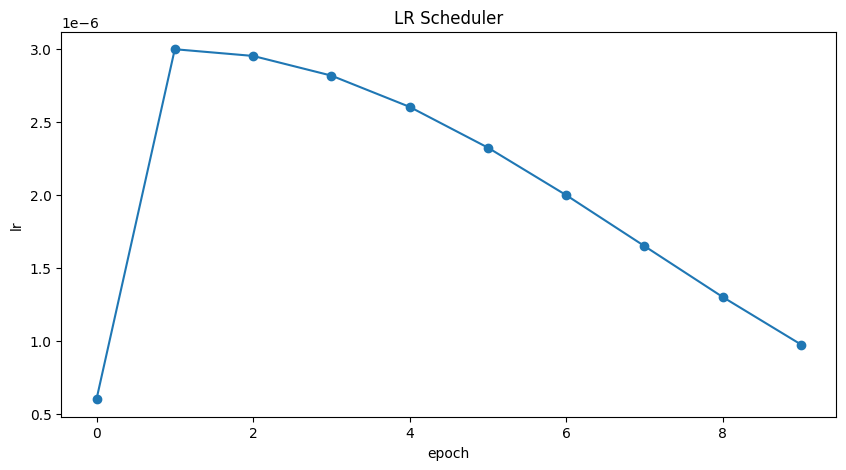

In [21]:
_=get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

# ☎️ | Callbacks

The function below will gather all the training callbacks, such as lr_scheduler, model_checkpoint, wandb_logger, and etc.

In [22]:
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)  # Get lr callback
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                              monitor='val_auc',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')  # Get Model checkpoint callback
    callbacks.extend([lr_cb, ckpt_cb])  # Add lr and checkpoint callbacks

    if CFG.wandb:  # If WandB is enabled
        wb_cbs = get_wb_callbacks(fold)  # Get WandB callbacks
        callbacks.extend(wb_cbs) 
        
    return callbacks  # Return the list of callbacks

# MY Contribution: 
# 🤖 | Modeling: Applying NBC

In [23]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Use CountVectorizer to convert text data into a bag-of-words representation
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)

# Initialize and train the Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, train_labels)

# Make predictions on the test set
predictions = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9526763559021624


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

# MY Contribution:
## Eperimenting different learning rates along wih the accuracy.


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

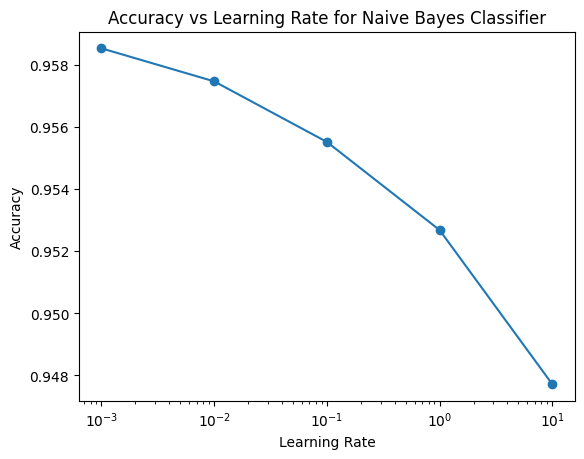

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'df' contains the data with 'text' and 'label' columns

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Use CountVectorizer to convert text data into a bag-of-words representation
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data)
X_test = vectorizer.transform(test_data)

# Different learning rates to try
learning_rates = [0.001, 0.01, 0.1, 1, 10]

# List to store accuracies
accuracies = []

# Train Naive Bayes classifiers with different learning rates
for lr in learning_rates:
    # Initialize and train the Naive Bayes Classifier
    nb_classifier = MultinomialNB(alpha=lr)  # Note: alpha is the smoothing parameter, equivalent to learning rate in this case
    nb_classifier.fit(X_train, train_labels)

    # Make predictions on the test set
    predictions = nb_classifier.predict(X_test)

    # Calculate accuracy and store it
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

# Plot the accuracies for different learning rates
plt.plot(learning_rates, accuracies, marker='o')
plt.xscale('log')  # Use a log scale for better visualization
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate for Naive Bayes Classifier')
plt.show()


# MY Contribution:
## Extera experimental work

# a. Build a vocabulary as a list.

In [25]:
# Build a vocabulary as a list
all_texts = df.text.tolist() + ext_df.text.tolist()
word_counts = {}

for text in all_texts:
    words = text.lower().split()
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Create a vocabulary, omitting rare words (occurrence less than five times)
vocab = [word for word, count in word_counts.items() if count >= 5]

# A reverse index as the key value
word_index = {word: index for index, word in enumerate(vocab)}

# b. Calculate the following probability:

In [26]:
# Calculate probability of occurrence
num_documents = len(all_texts)
occurrence_probability = {word: count / num_documents for word, count in word_counts.items()}

# Build a vocabulary as a list
all_texts = df.text.tolist() + ext_df.text.tolist()
word_counts = {}

for text in all_texts:
    words = text.lower().split()
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Create a vocabulary, omitting rare words (occurrence less than five times)
vocab = [word for word, count in word_counts.items() if count >= 5]

# A reverse index as the key value
word_index = {word: index for index, word in enumerate(vocab)}

# Calculate conditional probability based on the class (human or LLM)
class_counts = {'human': 0, 'LLM': 0}
class_occurrence_counts = {'human': {}, 'LLM': {}}

for index, row in df.iterrows():
    text = row['text']
    label = row['name']

    # Map the 'name' values to 'human' and 'LLM'
    label = 'human' if label == 'real' else 'LLM'

    words = text.lower().split()

    class_counts[label] += 1

    for word in words:
        if word in vocab:
            class_occurrence_counts[label][word] = class_occurrence_counts[label].get(word, 0) + 1


# Calculate conditional probabilities
conditional_probabilities = {
    word: {
        label: class_occurrence_counts[label].get(word, 0) / class_counts[label]
        if label in class_occurrence_counts and word in class_occurrence_counts[label]
        else 0
        for label in class_counts
    }
    for word in vocab
}


# c. Calculate accuracy using the dev dataset

In [27]:
def get_datasets(fold):
    train_df = df.sample(frac=1)  # Shuffle the entire DataFrame
    train_df['fold'] = -1  # Assign a default fold value for training data

    # Assign folds for k-fold cross-validation
    fold_size = len(train_df) // CFG.num_folds
    for i in range(CFG.num_folds):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size
        train_df.loc[start_idx:end_idx, 'fold'] = i

    train_df = train_df[train_df['fold'] != fold]  # Get training fold data

    train_texts = train_df.text.tolist()  # Extract training texts
    train_labels = train_df.label.tolist()  # Extract training labels

    # Build training dataset
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size, cache=CFG.cache,
                             shuffle=True, drop_remainder=True, repeat=True)

    valid_df = train_df[train_df['fold'] == fold]  # Get validation fold data
    valid_texts = valid_df.text.tolist()  # Extract validation texts
    valid_labels = valid_df.label.tolist()  # Extract validation labels

    # Build validation dataset
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=CFG.batch_size, cache=CFG.cache,
                             shuffle=False, drop_remainder=True, repeat=False)

    # Preprocess the validation dataset
    X_valid = []
    for text in valid_texts:
        words = text.lower().split()
        features = np.zeros(len(vocab))
        for word in words:
            if word in vocab:
                features[word_index[word]] += 1
        X_valid.append(features)

    # Convert to NumPy array
    X_valid = np.array(X_valid)

    return (train_ds, train_df), (valid_ds, valid_df, X_valid)  # Return datasets and dataframes


In [28]:
import matplotlib.pyplot as plt

# Assuming you want to train on folds 0, 1, and 2, and validate on fold 3
CFG.selected_folds = [0, 1, 2]
fold_to_validate = 3

# Lists to store fold numbers and corresponding accuracies
fold_numbers = []
accuracies = []

# Create the CountVectorizer outside the loop
vectorizer = CountVectorizer()

for fold in CFG.selected_folds:
    if fold == fold_to_validate:
        (train_ds, train_df), (valid_ds, valid_df, X_valid) = get_datasets(fold=fold)

        # Assuming you have already defined 'X_train' and 'y_train' within 'get_datasets'
        # Train Multinomial Naive Bayes classifier
        nb_classifier = MultinomialNB()

        # Convert text data to numerical features using Count Vectorization
        X_train_counts = vectorizer.fit_transform(train_df['text'])
        X_valid_counts = vectorizer.transform(valid_df['text'])

        nb_classifier.fit(X_train_counts, train_df['label'])

        # Make predictions on the validation set
        valid_predictions = nb_classifier.predict(X_valid_counts)

        # Extract true labels for validation set
        y_valid = valid_df['label']

        # Evaluate accuracy
        accuracy = accuracy_score(y_valid, valid_predictions)
        print(f'Accuracy on validation dataset for fold {fold}: {accuracy:.4f}')

        # Store fold number and accuracy
        fold_numbers.append(fold)
        accuracies.append(accuracy)

# # Plot the results
# plt.figure(figsize=(8, 4))
# plt.plot(fold_numbers, accuracies, marker='o')
# plt.xlabel('Fold Number')
# plt.ylabel('Accuracy')
# plt.title('Validation Accuracy for Each Fold')
# plt.show()


# d. Perform experiments

In [29]:
# Compare the effect of smoothing
# You can experiment with different values of alpha for smoothing

# Derive Top 10 words that predict each class
top_words_human = sorted(vocab, key=lambda word: conditional_probabilities[word]['human'], reverse=True)[:10]
top_words_LLM = sorted(vocab, key=lambda word: conditional_probabilities[word]['LLM'], reverse=True)[:10]

# Print top words for each class
print("Top 10 words predicting human essays:", top_words_human)
print("Top 10 words predicting LLM essays:", top_words_LLM)


Top 10 words predicting human essays: ['the', 'to', 'and', 'a', 'of', 'in', 'that', 'is', 'you', 'they']
Top 10 words predicting LLM essays: ['and', 'to', 'the', 'a', 'of', 'in', 'can', 'that', 'for', 'is']
